### 사고가 많이 발생하는 고속국도에서의 골든 타임을 확보하기 위한 병원 입지 선정 

#### 사용 모듈

In [1]:
import mglearn
import calplot
import datetime
import platform
import numpy as np
import pandas as pd
import seaborn as sb
from tqdm import tqdm
from scipy import stats
import sklearn.metrics as m
import statsmodels.api as sm
from itertools import chain, combinations
# pd.set_option('display.max_columns', None)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False
import plotly.graph_objs as go

from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
from sklearn.ensemble import VotingClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso, ElasticNet

import warnings
warnings.simplefilter('ignore')

### 분석 전 사고 방향
#### Step1. 고속국도 위에서 사고를 일으키는 요인에 대한 분석을 진행.

#### Step2. 사고가 발생한 발생지_시도 또는 발생지_시군구별에 대한 위험도 계산.
- 즉, 사고 위험도에 대한 공식을 세우고(찾고), 각 행에 대한 위험도를 계산한 위험도 컬럼을 생성.
- 위험도에 대한 예측을 진행? 위험도에 대한 분류를 하는 것이 맞는가? <--- 머신러닝과 딥러닝
- 여기서 필요한 작업 -> 각 시군구 별 위경도 데이터 확보가 무조건 필요.

#### Step3. 각 분류별 응급실 + 휴게소 분포 현황에 대한 분석이 필요.
- 휴게소와 사고와의 관계가 클까?
- 응급실과 사고와의 관계가 클까?

#### Step4. 기타 고려 사항이 필요.


#### Step5. 위 스텝을 모두 고려한 시각화 진행.

#### 데이터 읽기

In [2]:
# 2017년 ~ 2019년 고속국도 내 사고 현황 데이터 불러오기.
df = pd.read_csv('C:/Users/user/Desktop/express accident1.csv')
df.shape

(12448, 34)

### 데이터 명세서

#### 데이터 변수
- 변수(feature) 개수 : 36개
---
- **발생일** 
    - 2017년 ~ 2019년 Calmap을 통한 일별 사고 건수 표현. 일별 Risk 표현.
    - 일별, 월별, 요일에 따른 위험도 및 사고 건수 확인.
---
- **발생시간** 
    - 0 ~ 24시 사이에서 발생한 사고 건수 및 시간대별 리스크 표현.
    - 막대 그래프(1시간 단위) dodge, 파이차트(출퇴근, 오전, 오후, 퇴근, 밤, 새벽)
---
- **발생지_시도** 
    - 권역별 사고건수 및 리스크 위주의 파악.
    - 막대그래프 dodge.
---
- **발생지_시군구**
    - 지역별 사고건수 및 리스크 위주의 파악.
    - 막대그래프 dodge.
---
- **요일**
    - 요일별 사고건수 및 리스크 위주의 파악.
    - 막대그래프 dodge.
---
- **사고내용**
    - 중상, 사망 빈도 표현.
---
- **사고유형_대분류**
    - 차대차, 차대 사람, 차량 단독
---
- **사고유형_중분류**
    - 아래 항목에 대한 막대그래프 표현.
        - 공작물충돌
        - 길 가장자리 구역 통행중
        - 도로 이탈
        - 보도 통행중
        - 전도 : 자동차의 측면이 도로에 접한 상태로 넘어진 사고.
        - 전복 : 운행중의 사고로 인해 자동차가 뒤집어진 사고.
        - 추돌 : 주행 중 앞차가 급정거를 하고, 뒤쫓아가던 차가 부딪히는 사고.
        - 전도전복
        - 정면충돌
        - 차도통행중
        - 횡단중
        - 측면충돌
        - 후진중 충돌
        - 기타 
---
- **사고유형**
    - 공작물 충돌에 대한 빈도 표현.
    - 막대그래프 dodge.
    
---
- **가해자법규위반**
    - 안전 의무 빈도 표현. 
    
---
- **가해자성별**
- **피해자성별**
    - 가해자 및 피해자 안전, 의무 빈도 표현.
---
- **가해자연령**
- **피해자연령**
    - 가해자 및 피해자 연령별에 따른 리스크 및 사고건수 표현
---
#### 중요 요소 변수
- **가해당사자종별**
- **피해당사자종별**
    - 빈도 표현.(보류)
---
- **가해자신체상해정도**
- **피해자신체상해정도**
    - 가해자 및 피해자 신체 상해 정도 비교 표현.

---
- **가해차량용도_대분류**
- **가해차량용도_중분류**
- **가해차량용도**
---
- **피해차량용도_대분류**
- **피해차량용도_중분류** 
- **피해차량용도**
    - 6개중 차량 용도만을 사용하고, 2개만 사용.
    - 차량에 따른 발생지_시군구별 사고건수및 risk
---
- **도로종류**
    - 고속 국도 데이터이므로 삭제.

---
- **도로형태_대분류**
- **도로형태**
    - 삭제 예정

---
- **노면상태_대분류**
    - 포장, 비포장 라벨에 대한 데이터 불균형 문제로 삭제.

---    
- **노면상태**
- **기상상태**
    - 두 데이터 간의 상관관계 plot 파악.
    - 가중치 임의 및 기준을 이용하여 RISK 계산시 활용.(분석이 필요해 보임)

---
- **사망자수**
- **중상자수**
- **경상자수**
    - 시군구별에 따른 사망자, 중상자 수, 경상자 수 파악.
    - 발생시_시군구 데이터와의 분석 및 결합.

---
- **부상신고자수**
    - https://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1614
    - 교통사고 : * 집계 기준 : 차의 교통으로 인하여 발생한 인적피해를 수반하는 경찰접수 처리한 교통사고 기준.
        - 교통사고 사망자 기준 : 교통사고 발생일로 부터 30일 이내에 사망한 경우
        - 중상자 : 3주 이상의 치료를 요하는 부상자
        - 경상자 : 5일 이상 3주 미만의 치료를 요하는 부상자
        - 부상신고 : 5일 미만의 치료를 요하는 부상을 입은 경우

#### 데이터 전처리
- 데이터 삭제
    - 사고 유형의 경우 사고유형_중분류 데이터와의 중복으로 삭제.
    - 도로 종류는 고속국도로 한정시켜 가져온 데이터이므로 삭제.

In [3]:
# 필요없는 데이터 삭제.
df.drop(['도로형태', '도로형태_대분류', '도로종류', '사고유형', '노면상태_대분류'], axis = 1, inplace = True)
df.head()

,발생일,발생시간,발생지_시도,발생지_시군구,요일,사고내용,사고유형_대분류,사고유형_중분류,가해자법규위반,가해자성별,...,가해차량용도,피해차량용도_대분류,피해차량용도_중분류,피해차량용도,기상상태,노면상태,사망자수,중상자수,경상자수,부상신고자수
0,20170101,00시,경북,구미시,일,중상,차대차,추돌,안전운전 의무 불이행,남,...,승용차,비사업용,승용차,승용차,맑음,건조,0,8,0,1
1,20170101,02시,충남,홍성군,일,사망,차대차,추돌,안전운전 의무 불이행,남,...,승용차,비사업용,승용차,승용차,맑음,건조,1,0,1,0
2,20170101,03시,경북,상주시,일,경상,차대차,기타,안전운전 의무 불이행,남,...,위험물운송,사업용,렌터카,렌터카,맑음,건조,0,0,2,0
3,20170101,04시,서울,금천구,일,부상신고,차대차,측면충돌,기타,기타불명,...,불명,사업용,렌터카,렌터카,맑음,젖음/습기,0,0,0,1
4,20170101,07시,강원,강릉시,일,경상,차대차,추돌,안전운전 의무 불이행,여,...,승용차,비사업용,승용차,승용차,맑음,건조,0,0,4,0


#### 데이터 결측치 확인
- 결측치 확인 결과 결측은 존재하지 않음.

In [4]:
df.isna().sum()

발생일           0
발생시간          0
발생지_시도        0
발생지_시군구       0
요일            0
사고내용          0
사고유형_대분류      0
사고유형_중분류      0
가해자법규위반       0
가해자성별         0
가해자연령         0
가해당사자종별       0
가해자신체상해정도     0
피해자성별         0
피해자연령         0
피해당사자종별       0
피해자신체상해정도     0
가해차량용도_대분류    0
가해차량용도_중분류    0
가해차량용도        0
피해차량용도_대분류    0
피해차량용도_중분류    0
피해차량용도        0
기상상태          0
노면상태          0
사망자수          0
중상자수          0
경상자수          0
부상신고자수        0
dtype: int64

#### 시군구 별에 따른 응급실 수

In [5]:
df_응급실 = pd.read_csv('C:/Users/user/Desktop/응급실 최종.csv')
df_응급실.columns = ['이름', '주소', '시도', '시군구', 'lat', 'lon']
응급 = df_응급실['시군구'].value_counts()
응급_dic = {n : i for i, n in zip(응급.values, 응급.index)}
응급_count = [0  if str(응급_dic.get(i)) == 'None' else 응급_dic.get(i) for i in df['발생지_시군구']]
df['응급실 개수'] = 응급_count

#### 시군구 별에 따른 인구 데이터

In [6]:
df_인구 = pd.read_csv('C:/Users/user/Desktop/도시지역_인구현황_시군구__20210813095003.csv', encoding='euc-kr')
df_인구.index = df_인구['소재지(시군구)별(2)']
df_인구1 = df_인구[['2017', '2018', '2019']]
df_인구2 = df_인구1.drop(['소계'])[2:]

# 미주홀구에 대한 결측이 존재하여, 존재하는 연도의 평균으로 대치.
df_인구2['2017'] = [412702.0 if str(i) == '-' else i for i in df_인구2['2017']]
df_인구2['2018'] = [np.nan if str(i) == '-' else i for i in df_인구2['2018']]
df_인구2['2019'] = [np.nan if str(i) == '-' else i for i in df_인구2['2019']]

df_인구3 = df_인구2.dropna()
df_인구3 = df_인구3.astype('int')
b = round(df_인구3.mean(axis=1))

인구_dic = {i : j for i , j in zip(b.index, b.values)}
인구_count = [0  if str(인구_dic.get(i)) == 'None' else 인구_dic.get(i) for i in df['발생지_시군구']]
df['시군구별_인구'] = 인구_count

#### Risk 가중치 계산
- http://taas.koroad.or.kr/TCFS/

In [7]:
df['Risk'] = (df['사망자수'] * 12) + (df['중상자수'] * 3) + (df['경상자수'] * 1) + (df['부상신고자수'] * 1) 
df.head()

,발생일,발생시간,발생지_시도,발생지_시군구,요일,사고내용,사고유형_대분류,사고유형_중분류,가해자법규위반,가해자성별,...,피해차량용도,기상상태,노면상태,사망자수,중상자수,경상자수,부상신고자수,응급실 개수,시군구별_인구,Risk
0,20170101,00시,경북,구미시,일,중상,차대차,추돌,안전운전 의무 불이행,남,...,승용차,맑음,건조,0,8,0,1,3,421012.0,25
1,20170101,02시,충남,홍성군,일,사망,차대차,추돌,안전운전 의무 불이행,남,...,승용차,맑음,건조,1,0,1,0,1,101025.0,13
2,20170101,03시,경북,상주시,일,경상,차대차,기타,안전운전 의무 불이행,남,...,렌터카,맑음,건조,0,0,2,0,2,100644.0,2
3,20170101,04시,서울,금천구,일,부상신고,차대차,측면충돌,기타,기타불명,...,렌터카,맑음,젖음/습기,0,0,0,1,1,233960.0,1
4,20170101,07시,강원,강릉시,일,경상,차대차,추돌,안전운전 의무 불이행,여,...,승용차,맑음,건조,0,0,4,0,4,213450.0,4


In [8]:
df.to_csv('total_data.csv')

In [9]:
# a1 = df[['Risk', '발생지_시군구']]
# a2 = a1.groupby('발생지_시군구').sum()
# {n : i[0] for n, i in zip(a2.index, a2.values)}

#### 발생일

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


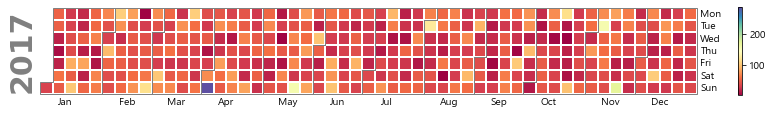

In [10]:
data_2017 = pd.DataFrame()
df1 = df.copy()
df2 = df1[['발생일', 'Risk']]
df_2017_time = list(set([i for j, i in enumerate(df2['발생일']) if '2017' in str(i)]))
df2['발생일'] = df2['발생일'].astype('str')
df2['발생일'] = pd.to_datetime(df2['발생일'])
df2.index = df2['발생일']
df3 = df2[:4146].drop(['발생일'], axis = 1)
df4 = df3.groupby([df3.index.month, df3.index.day] ).sum()
data_2017['Date'] = df_2017_time
data_2017['Risk'] = df4['Risk'].values
data_2017['Date'] = data_2017['Date'].astype('str')
data_2017.index = pd.to_datetime(data_2017['Date'])
calplot.calplot(data_2017['Risk'], cmap='Spectral', colorbar=True)
plt.show()

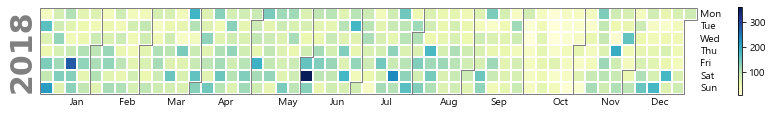

In [11]:
data_2018 = pd.DataFrame()
df1 = df.copy()
df2 = df1[['발생일', 'Risk']]
df_2018_time = list(set([i for j, i in enumerate(df2['발생일']) if '2018' in str(i)]))
df2['발생일'] = df2['발생일'].astype('str')
df2['발생일'] = pd.to_datetime(df2['발생일'])
df2.index = df2['발생일']
df3 = df2[416:8225].drop(['발생일'], axis = 1)
df4 = df3.groupby([df3.index.month, df3.index.day] ).sum()
data_2018['Date'] = df_2018_time
data_2018['Risk'] = df4['Risk'].values
data_2018['Date'] = data_2018['Date'].astype('str')
data_2018.index = pd.to_datetime(data_2018['Date'])
calplot.calplot(data_2018['Risk'], cmap='YlGnBu', colorbar=True)
plt.show()

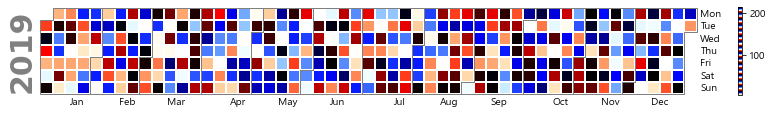

In [12]:
data_2019 = pd.DataFrame()
df1 = df.copy()
df2 = df1[['발생일', 'Risk']]
df_2019_time = list(set([i for j, i in enumerate(df2['발생일']) if '2019' in str(i)]))
df2['발생일'] = df2['발생일'].astype('str')
df2['발생일'] = pd.to_datetime(df2['발생일'])
df2.index = df2['발생일']
df3 = df2[8225:].drop(['발생일'], axis = 1)
df4 = df3.groupby([df3.index.month, df3.index.day] ).sum()
data_2019['Date'] = df_2019_time
data_2019['Risk'] = df4['Risk'].values
data_2019['Date'] = data_2019['Date'].astype('str')
data_2019.index = pd.to_datetime(data_2019['Date'])
calplot.calplot(data_2019['Risk'], cmap='flag', colorbar=True)
plt.show()

#### 발생시간

- 시간대별 사고 건수

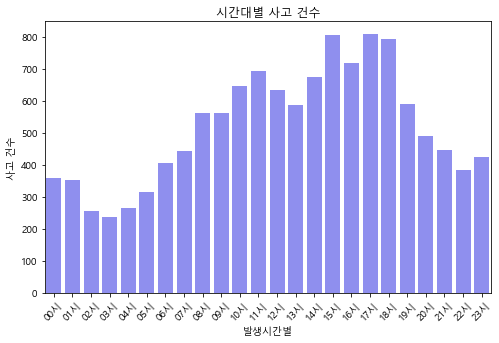

In [13]:
df_time = df[['발생시간','Risk']]
df_time_s = df_time.sort_values(by='발생시간')

plt.figure(figsize = (8, 5))
sb.countplot(data = df_time_s, x = '발생시간', color = 'blue', alpha=.5)
plt.xticks(rotation = 45)
plt.title('시간대별 사고 건수')
plt.xlabel('발생시간별')
plt.ylabel('사고 건수')
plt.show()

- 시간대별 Risk

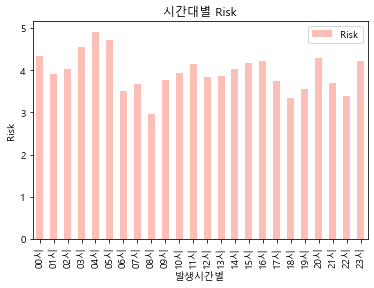

In [14]:
df_time_group = df_time_s.groupby('발생시간')
df_time_group = pd.DataFrame(df_time_group.mean()['Risk'])
df_time_group.plot(kind='bar', color='salmon', alpha=0.5)
plt.title('시간대별 Risk')
plt.xlabel('발생시간별')
plt.ylabel('Risk')
plt.show()

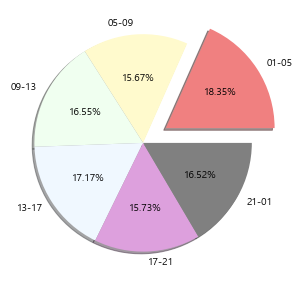

In [15]:
a = df_time_group.loc['01시':'04시'].mean()
b = df_time_group.loc['05시':'08시'].mean()
c = df_time_group.loc['09시':'12시'].mean()
d = df_time_group.loc['13시':'16시'].mean()
e = df_time_group.loc['17시':'20시'].mean()
f = df_time_group.loc[['21시', '22시', '23시', '00시']].mean()
date = pd.DataFrame()
date['01-05'] = a
date['05-09'] = b
date['09-13'] = c
date['13-17'] = d
date['17-21'] = e
date['21-01'] = f

col = ['lightcoral','lemonchiffon', 'honeydew', 'aliceblue', 'plum', 'grey']
labels = ['01-05', '05-09', '09-13','13-17','17-21', '21-01' ]
explode =  0.25, 0, 0, 0, 0, 0
plt.figure(figsize=(8, 5))
plt.pie(date.T['Risk'].values, labels=labels, autopct='%.2f%%', shadow=True, explode=explode, colors=col)
plt.show()

In [16]:
df['발생시간'] = [i.split('시')[0] for i in df['발생시간']]
df['발생시간'] = df['발생시간'].astype('int64')

#### 문자열 Encoding
- 문자열로 이루어진 데이터에 대한 인코딩 작업.
    - **Label encoding**
    - OneHot encoding
    - pd.get_dummies
    - replace
    - make_column_transformer

#### 발생지_시도 encoding
- 강원, 경기, 경남, 경북, 광주, 대구, 대전, 부산, 서울, 세종, 울산, 인천, 전남, 전북, 충남, 충북
- 2017년 ~ 2019년 경기 인근 고속국도에서의 사고 건수가 압도적으로 많음.

In [17]:
lbl1 = LabelEncoder()
Data_Label1 = lbl1.fit_transform( df['발생지_시도'] )
Data_Label1

array([ 3, 14,  3, ...,  1,  1,  1])

In [18]:
df_발생지_시도_dic = { idx : local for idx, local in enumerate(list(lbl1.classes_)) }
df_발생지_시도_dic

{0: '강원',
 1: '경기',
 2: '경남',
 3: '경북',
 4: '광주',
 5: '대구',
 6: '대전',
 7: '부산',
 8: '서울',
 9: '세종',
 10: '울산',
 11: '인천',
 12: '전남',
 13: '전북',
 14: '충남',
 15: '충북'}

- 권역별 사고 건수 빈도

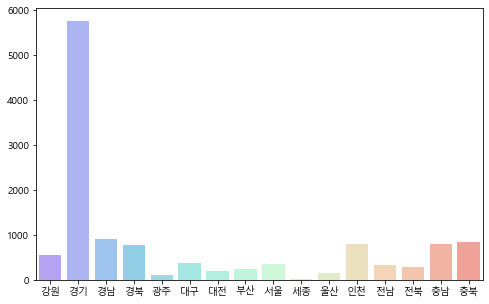

In [19]:
local_list = [ df_발생지_시도_dic.get(i) for i in Data_Label1 ]
local_df = pd.DataFrame(local_list).value_counts()
b1 = [i[0] for i in local_df.index]
b2 = local_df.values
acc = pd.DataFrame()
acc['권역'] = b1
acc['사고건수'] = b2
acc1 = acc.sort_values(by='권역')
plt.figure(figsize=(8, 5))
sb.barplot(acc1['권역'].values, acc1['사고건수'].values, palette='rainbow', alpha=.5)
plt.show()

- 권역별 사고 리스크 Level

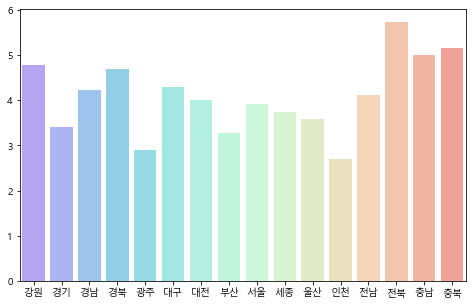

In [20]:
df_발생지_시도_risk = df[['발생지_시도', 'Risk']].groupby('발생지_시도').mean()
a1 = list(df_발생지_시도_risk.index)
a2 = [i[0] for i in df_발생지_시도_risk.values]
risk = pd.DataFrame()
risk['권역'] = a1
risk['Risk_mean'] = a2
plt.figure(figsize=(8, 5))
sb.barplot(risk['권역'].values, risk['Risk_mean'].values, palette='rainbow', alpha=.5)
plt.show()

In [21]:
df['발생지_시도'] = Data_Label1

#### 발생지_시군구 encoding
- 총 148개의 지역에서 사고가 발생.
- 서울 용인시, 경기 성남시, 경기 화성시 , 경기 평택시, 경남 김해시 순으로 사고 발생이 많았음.

In [22]:
lbl2 = LabelEncoder()
Data_Label2 = lbl2.fit_transform( df['발생지_시군구'] )
Data_Label2

array([ 25, 155,  70, ..., 148, 157, 157])

In [23]:
df_발생지_시군구_dic = { idx : local for idx, local in enumerate(list(lbl2.classes_)) }
df_발생지_시군구_dic

{0: '가평군',
 1: '강남구',
 2: '강동구',
 3: '강릉시',
 4: '강서구',
 5: '강진군',
 6: '거창군',
 7: '경산시',
 8: '경주시',
 9: '계룡시',
 10: '계양구',
 11: '고령군',
 12: '고성군',
 13: '고양시',
 14: '고창군',
 15: '곡성군',
 16: '공주시',
 17: '과천시',
 18: '광명시',
 19: '광산구',
 20: '광양시',
 21: '광주시',
 22: '괴산군',
 23: '구례군',
 24: '구리시',
 25: '구미시',
 26: '군산시',
 27: '군위군',
 28: '군포시',
 29: '금산군',
 30: '금정구',
 31: '금천구',
 32: '기장군',
 33: '김제시',
 34: '김천시',
 35: '김포시',
 36: '김해시',
 37: '나주시',
 38: '남동구',
 39: '남양주시',
 40: '남원시',
 41: '노원구',
 42: '논산시',
 43: '단양군',
 44: '달서구',
 45: '달성군',
 46: '담양군',
 47: '당진시',
 48: '대덕구',
 49: '동구',
 50: '동해시',
 51: '목포시',
 52: '무안군',
 53: '무주군',
 54: '문경시',
 55: '미추홀구',
 56: '밀양시',
 57: '보령시',
 58: '보성군',
 59: '보은군',
 60: '부안군',
 61: '부여군',
 62: '부천시',
 63: '부평구',
 64: '북구',
 65: '사상구',
 66: '사천시',
 67: '사하구',
 68: '산청군',
 69: '삼척시',
 70: '상주시',
 71: '서구',
 72: '서산시',
 73: '서천군',
 74: '서초구',
 75: '성남시',
 76: '성북구',
 77: '성주군',
 78: '세종시',
 79: '속초시',
 80: '송파구',
 81: '수성구',
 82: '수원시',
 83: '순창군',
 84

In [24]:
local_list2 = [ df_발생지_시군구_dic.get(i) for i in Data_Label2 ]
local_df2 = pd.DataFrame(local_list2).value_counts()
local_df2[:10]

용인시    844
성남시    570
화성시    490
천안시    349
평택시    333
김해시    333
시흥시    331
하남시    299
청주시    284
안성시    268
dtype: int64

- 사고 건수가 가장 많이 발생하는 지역 TOP 10

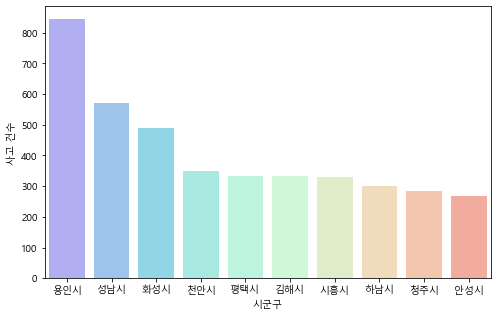

In [25]:
plt.figure(figsize = (8, 5))
sb.barplot([i[0] for i in list(local_df2[:10].index)], local_df2[:10].values, palette='rainbow', alpha=.5)
plt.xlabel('시군구')
plt.ylabel('사고 건수')
plt.show()

- 사고 리스크가 가장 큰 지역 TOP10

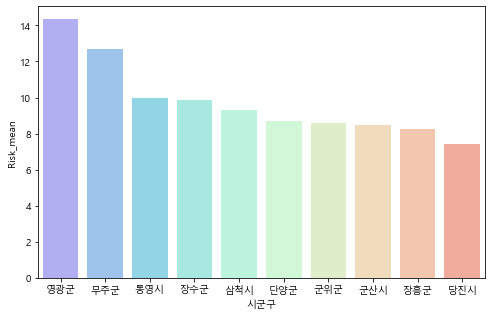

In [26]:
df1 = df[['발생지_시군구', 'Risk']]
df1['발생지_시군구'] = ['창원시' if '통합' in i else i  for i in df1['발생지_시군구']]
df2 = df1.groupby('발생지_시군구').mean()
df3 = df2.sort_values(by='Risk', ascending=False)[:10]

top10 = []
for i in list(df3.index) :
    top10.append(i)
    
plt.figure(figsize = (8, 5))
sb.barplot(top10, [i[0] for i in df3.values], palette='rainbow', alpha=.5)
plt.xlabel('시군구')
plt.ylabel('Risk_mean')
plt.show()

In [27]:
df['발생지_시군구'] = Data_Label2

#### 요일 encoding
- 월, 화, 수, 목, 금 , 토, 일
- 평일(월 ~ 금), 주말(토 ~ 일)
- 토요일, 금요일의 사고 빈도수가 가장 높음.
- 의외로 일요일 사고건수가 가장 낮게 나옴.

In [28]:
lbl3 = LabelEncoder()
Data_Label3 = lbl3.fit_transform( df['요일'] )
Data_Label3

array([4, 4, 4, ..., 6, 6, 6])

In [29]:
df_요일_dic = { idx : day for idx, day in enumerate(list(lbl3.classes_)) }
df_요일_dic

{0: '금', 1: '목', 2: '수', 3: '월', 4: '일', 5: '토', 6: '화'}

In [30]:
b1 = [i[0] for i in local_df.index]
b2 = local_df.values
acc = pd.DataFrame()
acc['권역'] = b1
acc['사고건수'] = b2
acc1 = acc.sort_values(by='권역')

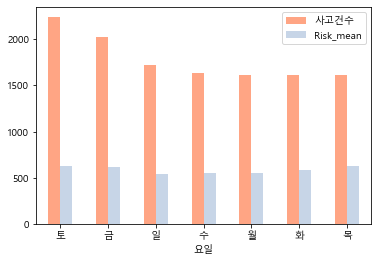

In [31]:
local_list3 = [ df_요일_dic.get(i) for i in Data_Label3 ]
local_df3 = pd.DataFrame(local_list3).value_counts()

day = pd.DataFrame()
day['요일'] = [i[0] for i in local_df3.index]
day['사고건수'] = local_df3.values

# df[['요일', 'Risk']].groupby('요일').mean()
day['Risk_mean'] = [7.862475 * 80, 7.677824 * 80, 6.795964 * 80, 6.949886 * 80, 6.845606 * 80, 7.326139 * 80, 7.881266 * 80] 
day.index = day['요일']

# plt.figure(figsize=(8, 5))
# sb.barplot([i[0] for i in list(local_df3.index)], local_df3.values, palette='rainbow', alpha=.5)
# plt.xlabel('요일')
# plt.ylabel('사고 건수')
# plt.show()

day.plot(kind='bar', y=['사고건수','Risk_mean'], color=['coral', 'lightsteelblue'], alpha=0.7, rot=0)
plt.show()

In [32]:
df['요일'] = Data_Label3

#### 사고내용 encoding
- 사망
- 중상

In [33]:
lbl4 = LabelEncoder()
Data_Label4 = lbl4.fit_transform( df['사고내용'] )
Data_Label4

array([3, 2, 0, ..., 0, 0, 0])

In [34]:
df_사고내용_dic = { idx : acc for idx, acc in enumerate(list(lbl4.classes_)) }
df_사고내용_dic

{0: '경상', 1: '부상신고', 2: '사망', 3: '중상'}

In [35]:
local_list4 = [ df_사고내용_dic.get(i) for i in Data_Label4 ]
local_df4 = pd.DataFrame(local_list4).value_counts()
serious, death = local_df4.values[0], local_df4.values[-1]
total = serious + death
print(f'Results : \n Total Data  : {total}\n Rate of death : {death} ({(death/total*100):.2f}%)\n')

Results : 
 Total Data  : 8122
 Rate of death : 484 (5.96%)



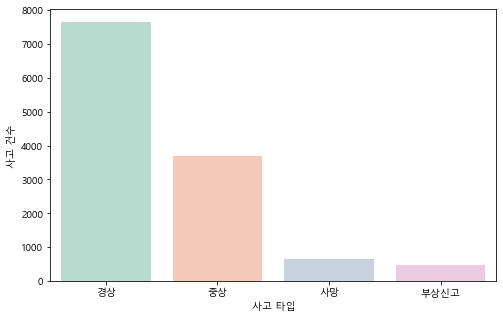

In [36]:
plt.figure(figsize=(8, 5))
sb.barplot([i[0] for i in list(local_df4.index)], local_df4.values, palette='Set2', alpha=.5)
plt.xlabel('사고 타입')
plt.ylabel('사고 건수')
plt.show()

In [37]:
df['사고내용'] = Data_Label4

#### 사고유형_대분류 encoding
- 차대 사람
- 차대차 
- 차량 단도

- 차대차 사람의 비율이 압도적으로 높음. 즉, 고속국도 위에서 차와 차 사이에서 발생하는 사고가 가장 많음.

In [38]:
lbl5 = LabelEncoder()
Data_Label5 = lbl5.fit_transform( df['사고유형_대분류'] )
Data_Label5

array([1, 1, 1, ..., 1, 1, 1])

In [39]:
df['사고유형_대분류'] = Data_Label5

In [40]:
df_사고유형_대분류_dic = { idx : car for idx, car in enumerate(list(lbl5.classes_)) }
df_사고유형_대분류_dic

{0: '차대사람', 1: '차대차', 2: '차량단독'}

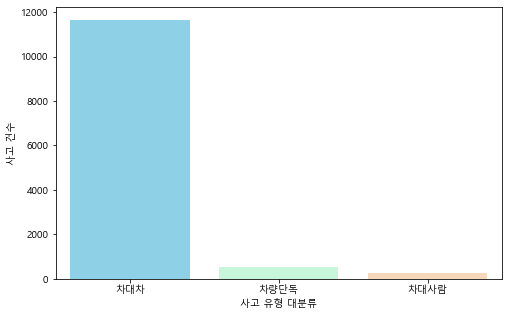

In [41]:
local_list5 = [ df_사고유형_대분류_dic.get(i) for i in Data_Label5 ]
local_df5 = pd.DataFrame(local_list5).value_counts()
plt.figure(figsize=(8, 5))
sb.barplot([i[0] for i in list(local_df5.index)], local_df5.values, palette='rainbow', alpha=.5)
plt.xlabel('사고 유형 대분류')
plt.ylabel('사고 건수')
plt.show()

#### 사고유형_중분류
- 공작물충돌
- 길 가장자리 구역 통행중
- 도로 이탈
- 보도 통행중
- 전도 : 자동차의 측면이 도로에 접한 상태로 넘어진 사고.
- 전복 : 운행중의 사고로 인해 자동차가 뒤집어진 사고.
- 추돌 : 주행 중 앞차가 급정거를 하고, 뒤쫓아가던 차가 부딪히는 사고.
- 전도전복
- 정면충돌
- 차도통행중
- 횡단중
- 측면충돌
- 후진중 충돌
- 기타 

- **추돌 사고가 굉장히 많이 발생함. 기타 사고 비율도 두 번째로 높으나 기타가 정확히 어떤 사항인지는 알 수가 없음.**
- **측면 충돌 사고의 비중 세번째로 높고, 나머지에 대한 사고는 거의 존재하지 않음.**

In [42]:
lbl6 = LabelEncoder()
Data_Label6 = lbl6.fit_transform( df['사고유형_중분류'] )
Data_Label6

array([11, 11,  1, ...,  1,  1,  1])

In [43]:
df['사고유형_중분류'] = Data_Label6

In [44]:
df_사고유형_중분류_dic = { idx : car for idx, car in enumerate(list(lbl6.classes_)) }
df_사고유형_중분류_dic

{0: '공작물충돌',
 1: '기타',
 2: '길가장자리구역통행중',
 3: '도로이탈',
 4: '보도통행중',
 5: '전도',
 6: '전도전복',
 7: '전복',
 8: '정면충돌',
 9: '주/정차차량 충돌',
 10: '차도통행중',
 11: '추돌',
 12: '측면충돌',
 13: '횡단중',
 14: '후진중충돌'}

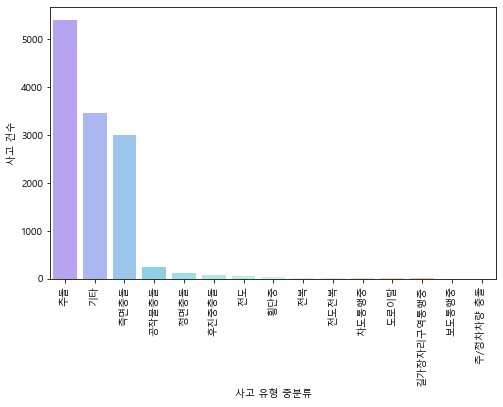

In [45]:
local_list6 = [ df_사고유형_중분류_dic.get(i) for i in Data_Label6 ]
local_df6 = pd.DataFrame(local_list6).value_counts()
plt.figure(figsize=(8, 5))
sb.barplot([i[0] for i in list(local_df6.index)], local_df6.values, palette='rainbow', alpha=.5)
plt.xticks(rotation = 90)
plt.xlabel('사고 유형 중분류')
plt.ylabel('사고 건수')
plt.show()

#### 가해자법규위반
- 과속 
- 신호 위반
- 안전거리 미확보
- 안전 운전 의무 불이행
- 중앙선 침범

- **안전 운전 의무 불이행의 비율이 가장 높고, 안전 거리 미확보의 비율도 상대적인 관점에서 적지 않음.**

In [46]:
lbl7 = LabelEncoder()
Data_Label7 = lbl7.fit_transform( df['가해자법규위반'] )
Data_Label7

array([5, 5, 5, ..., 5, 4, 4])

In [47]:
df['가해자법규위반'] = Data_Label7

In [48]:
df_가해자법규위반_dic = { idx : man for idx, man in enumerate(list(lbl7.classes_)) }
df_가해자법규위반_dic

{0: '과속',
 1: '교차로 통행방법 위반',
 2: '기타',
 3: '신호위반',
 4: '안전거리 미확보',
 5: '안전운전 의무 불이행',
 6: '중앙선 침범'}

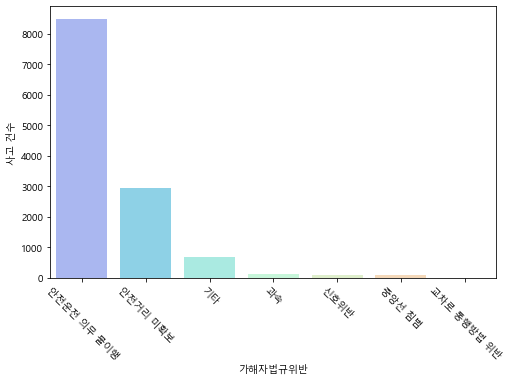

In [49]:
local_list7 = [ df_가해자법규위반_dic.get(i) for i in Data_Label7 ]
local_df7 = pd.DataFrame(local_list7).value_counts()
plt.figure(figsize=(8, 5))
sb.barplot([i[0] for i in list(local_df7.index)], local_df7.values, palette='rainbow', alpha=.5)
plt.xticks(rotation = -45)
plt.xlabel('가해자법규위반')
plt.ylabel('사고 건수')
plt.show()

#### 가해자 성별 & 피해자 성별
- 남
- 여
- 기타 불명

- **남자가 사고를 일으키는 경우가 압도적으로 많음.**

In [50]:
lbl8 = LabelEncoder()
Data_Label8 = lbl8.fit_transform( df['가해자성별'] )
Data_Label8

array([1, 1, 1, ..., 1, 1, 1])

In [51]:
lbl9 = LabelEncoder()
Data_Label9 = lbl9.fit_transform( df['피해자성별'] )
Data_Label9

array([3, 1, 1, ..., 1, 1, 1])

In [52]:
df_가해자성별_dic = { idx : sex for idx, sex in enumerate(list(lbl8.classes_)) }
df_가해자성별_dic

{0: '기타불명', 1: '남', 2: '여'}

In [53]:
df_피해자성별_dic = { idx : sex for idx, sex in enumerate(list(lbl8.classes_)) }
df_피해자성별_dic

{0: '기타불명', 1: '남', 2: '여'}

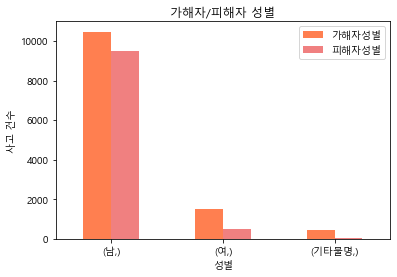

In [54]:
local_list8 = [ df_가해자성별_dic.get(i) for i in Data_Label8 ]
local_list9 = [ df_피해자성별_dic.get(i) for i in Data_Label9 ]

local_df8 = pd.DataFrame(local_list8).value_counts()
local_df9 = pd.DataFrame(local_list9).value_counts()

# sb.barplot([i[0] for i in list(local_df8.index)], local_df8.values, palette='Set2', alpha=.5)
# plt.xlabel('성별')
# plt.ylabel('사고 건수')

a=pd.DataFrame()
a['가해자성별']=local_df8
a['피해자성별']=local_df9

a=a.rename(index={'없음':'여'})

a.plot.bar(color=['coral', 'lightcoral'], rot=0)
plt.title('가해자/피해자 성별')
plt.xlabel('성별')
plt.ylabel('사고 건수')
plt.show()

In [55]:
df['가해자성별'] = Data_Label8
df['피해자성별'] = Data_Label9

#### 가해자연령
- 중장년층(40 ~ 60세)가 일으키는 사고 건수가 가장 많음.

In [56]:
lbl9 = LabelEncoder()
lbl10 = LabelEncoder()
Data_Label9 = lbl9.fit_transform( df['가해자연령'] )
Data_Label10 = lbl10.fit_transform( df['피해자연령'] )

In [57]:
df_가해자연령_dic = { idx : age for idx, age in enumerate(list(lbl9.classes_)) }
df_피해자연령_dic = { idx : age for idx, age in enumerate(list(lbl10.classes_)) }

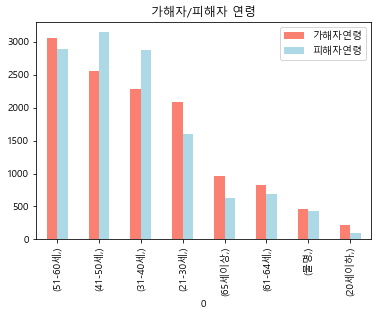

In [58]:
local_list9  = [ df_가해자연령_dic.get(i) for i in Data_Label9 ]
local_list10 = [ df_피해자연령_dic.get(i) for i in Data_Label10 ]
local_df9  = pd.DataFrame(local_list9).value_counts()
local_df10 = pd.DataFrame(local_list10).value_counts()

a = pd.DataFrame()
a['가해자연령'] = local_df9
a['피해자연령'] = local_df10

a.plot.bar(color=['salmon','lightblue'])
plt.title('가해자/피해자 연령')
plt.show()

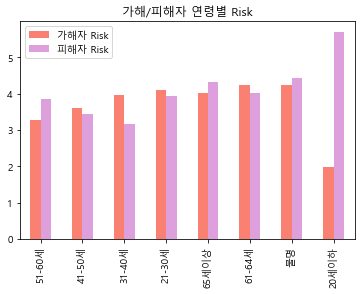

In [59]:
s = [i[0] for i in a.index]
df_age_1 = df[['가해자연령','Risk']]
df_age_s1 = df_age_1.sort_values(by='가해자연령')
df_age_group1 = df_age_s1.groupby(by='가해자연령')
df_age_group1 = df_age_group1.mean()

df_age_2 = df[['피해자연령','Risk']]
df_age_s2 = df_age_2.sort_values(by='피해자연령')
df_age_group2 = df_age_s2.groupby(by='피해자연령')
df_age_group2 = df_age_group2.mean()[:-1]

a = pd.DataFrame()
a['연령'] = s
a.index = s
a['가해자 Risk']=df_age_group1['Risk'].values
a['피해자 Risk']=df_age_group2['Risk'].values
a.drop(['연령'], axis=1, inplace=True)
a.plot.bar(color = ['salmon', 'plum'])
plt.title('가해/피해자 연령별 Risk')
plt.show()

In [60]:
df_age_group1 

,Risk
가해자연령,
20세이하,3.273973
21-30세,3.594919
31-40세,3.957168
41-50세,4.094044
51-60세,4.013076
61-64세,4.238443
65세이상,4.243750
불명,1.965368


In [61]:
df['가해자연령'] = Data_Label9
df['피해자연령'] = Data_Label10

#### 피해자 & 가해당사자종별
- 승용차, 화물차의 사고 빈도가 매우 높음
- 의외로 대형 사고 발생 가능성이 큰 화물차의 사고 빈도가 높다는 점에 주의

In [62]:
lbl10 = LabelEncoder()
Data_Label10 = lbl10.fit_transform( df['가해당사자종별'] )
lbl11 = LabelEncoder()
Data_Label11 = lbl11.fit_transform( df['피해당사자종별'] )

In [63]:
df_가해당사자종별_dic = { idx : age for idx, age in enumerate(list(lbl10.classes_)) }
df_피해당사자종별_dic = { idx : age for idx, age in enumerate(list(lbl11.classes_)) }

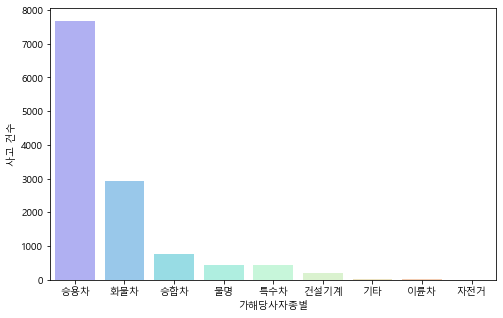

In [64]:
local_list10 = [ df_가해당사자종별_dic.get(i) for i in Data_Label10 ]
local_list11 = [ df_피해당사자종별_dic.get(i) for i in Data_Label11 ]
local_df10 = pd.DataFrame(local_list10).value_counts()
local_df11 = pd.DataFrame(local_list11).value_counts()
plt.figure(figsize=(8, 5))
sb.barplot([i[0] for i in list(local_df10.index)], local_df10.values, palette='rainbow', alpha=.5)
plt.xlabel('가해당사자종별')
plt.ylabel('사고 건수')
plt.show()

In [65]:
df['가해당사자종별'] = Data_Label10
df['피해당사자종별'] = Data_Label11

#### 피해자신체상해정도 & 가해자신체상해정도 
- 고속도로 위에서의 중상 비율이 매우 높음.

In [66]:
lbl13 = LabelEncoder()
lbl14 = LabelEncoder()
Data_Label13 = lbl13 .fit_transform( df['피해자신체상해정도'] )
Data_Label14 = lbl14.fit_transform( df['가해자신체상해정도'] )

In [67]:
df_피해자신체상해정도_dic = { idx : damage for idx, damage in enumerate(list(lbl13.classes_)) }
df_가해자신체상해정도_dic = { idx : damage for idx, damage in enumerate(list(lbl14.classes_)) }

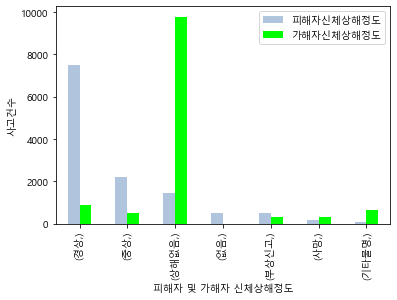

In [68]:
local_list13 = [ df_피해자신체상해정도_dic.get(i) for i in Data_Label13 ]
local_df13 = pd.DataFrame(local_list13).value_counts()

local_list14 = [ df_가해자신체상해정도_dic.get(i) for i in Data_Label14 ]
local_df14= pd.DataFrame(local_list14).value_counts()

# plt.figure(figsize=(8, 5))
# sb.barplot([i[0] for i in list(local_df11.index)], local_df11.values, palette='rainbow', alpha=.5)
# plt.xlabel('피해자신체상해정도')
# plt.ylabel('사고 건수')

신체상해정도비교_df = pd.DataFrame()
신체상해정도비교_df['피해자신체상해정도'] = local_df13
신체상해정도비교_df['가해자신체상해정도'] = local_df14

신체상해정도비교_df.plot.bar(color=['lightsteelblue', 'lime'])
plt.xlabel('피해자 및 가해자 신체상해정도')
plt.ylabel('사고건수')
plt.show()


In [69]:
df['피해자신체상해정도'] = Data_Label13
df['가해자신체상해정도'] = Data_Label14

#### 가해차량용도_대분류
- 비사업용 비율이 높은 것으로 보아, 일 도중 아닌 사고의 비율이 크다.

In [70]:
lbl12 = LabelEncoder()
Data_Label12 = lbl12.fit_transform( df['가해차량용도_대분류'] )
Data_Label12

array([2, 2, 3, ..., 2, 2, 2])

In [71]:
df['가해차량용도_대분류'] = Data_Label12

In [72]:
df_가해차량용도_대분류_dic = { idx : car for idx, car in enumerate(list(lbl12.classes_)) }
df_가해차량용도_대분류_dic 

{0: '기타', 1: '불명', 2: '비사업용', 3: '사업용', 4: '이륜차', 5: '자전거'}

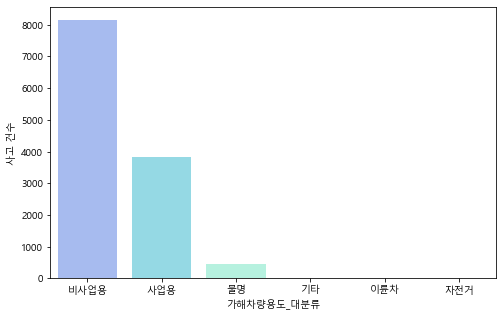

In [73]:
local_list12 = [ df_가해차량용도_대분류_dic.get(i) for i in Data_Label12 ]
local_df12 = pd.DataFrame(local_list12).value_counts()
plt.figure(figsize=(8, 5))
sb.barplot([i[0] for i in list(local_df12.index)], local_df12.values, palette='rainbow', alpha=.5)
plt.xlabel('가해차량용도_대분류')
plt.ylabel('사고 건수')
plt.show()

#### 가해차량용도_중분류
- 승용차, 화물차의 사고 건수가 가장 많음.

In [74]:
lbl13 = LabelEncoder()
Data_Label13 = lbl13.fit_transform( df['가해차량용도_중분류'] )
Data_Label13

array([7, 7, 9, ..., 7, 7, 7])

In [75]:
df['가해차량용도_중분류']  = Data_Label13

In [76]:
df_가해차량용도_중분류_dic = { idx : car for idx, car in enumerate(list(lbl13.classes_)) }
df_가해차량용도_중분류_dic 

{0: '기타',
 1: '기타/건설기계',
 2: '노선버스',
 3: '덤프트럭',
 4: '렌터카',
 5: '버스',
 6: '불명',
 7: '승용차',
 8: '어린이통학버스',
 9: '위험물운송',
 10: '이륜차',
 11: '자전거',
 12: '전세버스',
 13: '콘크리트믹서',
 14: '택시',
 15: '화물차'}

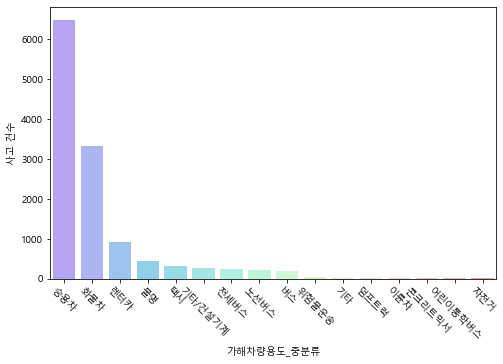

In [77]:
local_list13 = [ df_가해차량용도_중분류_dic.get(i) for i in Data_Label13 ]
local_df13 = pd.DataFrame(local_list13).value_counts()
plt.figure(figsize=(8, 5))
sb.barplot([i[0] for i in list(local_df13.index)], local_df13.values, palette='rainbow', alpha=.5)
plt.xticks(rotation = -45)
plt.xlabel('가해차량용도_중분류')
plt.ylabel('사고 건수')
plt.show()

#### 가해차량용도

In [78]:
lbl14 = LabelEncoder()
Data_Label14 = lbl14.fit_transform( df['가해차량용도'] )
Data_Label14

array([ 9,  9, 13, ...,  9,  9,  9])

In [79]:
df['가해차량용도'] = Data_Label14

In [80]:
df_가해차량용도_dic = { idx : car for idx, car in enumerate(list(lbl14.classes_)) }
df_가해차량용도_dic 

{0: '개인택시',
 1: '고속버스',
 2: '기타',
 3: '기타/건설기계',
 4: '덤프트럭',
 5: '렌터카',
 6: '버스',
 7: '법인택시',
 8: '불명',
 9: '승용차',
 10: '시내버스',
 11: '시외버스',
 12: '어린이통학버스',
 13: '위험물운송',
 14: '이륜차',
 15: '자전거',
 16: '전세버스',
 17: '콘크리트믹서',
 18: '화물차'}

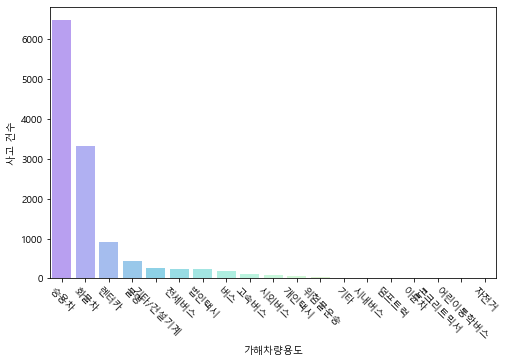

In [81]:
local_list14 = [ df_가해차량용도_dic.get(i) for i in Data_Label14 ]
local_df14 = pd.DataFrame(local_list14).value_counts()
plt.figure(figsize=(8, 5))
sb.barplot([i[0] for i in list(local_df14.index)], local_df14.values, palette='rainbow', alpha=.5)
plt.xticks(rotation = -45)
plt.xlabel('가해차량용도')
plt.ylabel('사고 건수')
plt.show()

#### 피해차량용도_대분류

In [82]:
lbl15 = LabelEncoder()
Data_Label15 = lbl15.fit_transform( df['피해차량용도_대분류'] )
Data_Label15

array([3, 3, 4, ..., 3, 4, 4])

In [83]:
df['피해차량용도_대분류'] = Data_Label15

In [84]:
df_피해차량용도_대분류_dic = { idx : car for idx, car in enumerate(list(lbl15.classes_)) }
df_피해차량용도_대분류_dic 

{0: '기타', 1: '보행자', 2: '불명', 3: '비사업용', 4: '사업용', 5: '없음', 6: '이륜차', 7: '자전거'}

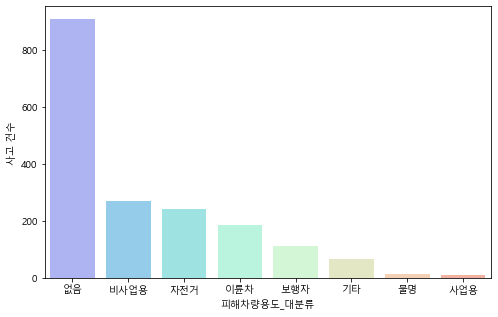

In [85]:
local_list14 = [ df_피해차량용도_대분류_dic.get(i) for i in Data_Label14 ]
local_df14 = pd.DataFrame(local_list14).value_counts()
plt.figure(figsize=(8, 5))
sb.barplot([i[0] for i in list(local_df14.index)], local_df14.values, palette='rainbow', alpha=.5)
plt.xlabel('피해차량용도_대분류')
plt.ylabel('사고 건수')
plt.show()

#### 피해차량용도_중분류

In [86]:
lbl16 = LabelEncoder()
Data_Label16 = lbl16.fit_transform( df['피해차량용도_중분류'] )
Data_Label16

array([ 8,  8,  4, ...,  8, 14, 18])

In [87]:
df['피해차량용도_중분류'] = Data_Label16

In [88]:
df_피해차량용도_중분류_dic = { idx : car for idx, car in enumerate(list(lbl16.classes_)) }
df_피해차량용도_중분류_dic 

{0: '기타',
 1: '기타/건설기계',
 2: '노선버스',
 3: '덤프트럭',
 4: '렌터카',
 5: '버스',
 6: '보행자',
 7: '불명',
 8: '승용차',
 9: '어린이통학버스',
 10: '없음',
 11: '위험물운송',
 12: '이륜차',
 13: '자전거',
 14: '전세버스',
 15: '콘크리트믹서',
 16: '택시',
 17: '특수여객(장의)',
 18: '화물차'}

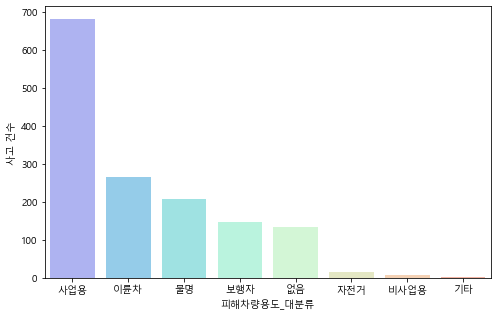

In [89]:
local_list16 = [ df_피해차량용도_대분류_dic.get(i) for i in Data_Label16 ]
local_df16 = pd.DataFrame(local_list16).value_counts()
plt.figure(figsize=(8, 5))
sb.barplot([i[0] for i in list(local_df16.index)], local_df16.values, palette='rainbow', alpha=.5)
plt.xlabel('피해차량용도_대분류')
plt.ylabel('사고 건수')
plt.show()

#### 피해차량용도

In [90]:
lbl17 = LabelEncoder()
Data_Label17 = lbl17.fit_transform( df['피해차량용도'] )
Data_Label17

array([11, 11,  5, ..., 11, 19, 22])

In [91]:
df['피해차량용도'] = Data_Label17

In [92]:
df_피해차량용도_dic = { idx : car for idx, car in enumerate(list(lbl17.classes_)) }
df_피해차량용도_dic 

{0: '개인택시',
 1: '고속버스',
 2: '기타',
 3: '기타/건설기계',
 4: '덤프트럭',
 5: '렌터카',
 6: '마을버스',
 7: '버스',
 8: '법인택시',
 9: '보행자',
 10: '불명',
 11: '승용차',
 12: '시내버스',
 13: '시외버스',
 14: '어린이통학버스',
 15: '없음',
 16: '위험물운송',
 17: '이륜차',
 18: '자전거',
 19: '전세버스',
 20: '콘크리트믹서',
 21: '특수여객(장의)',
 22: '화물차'}

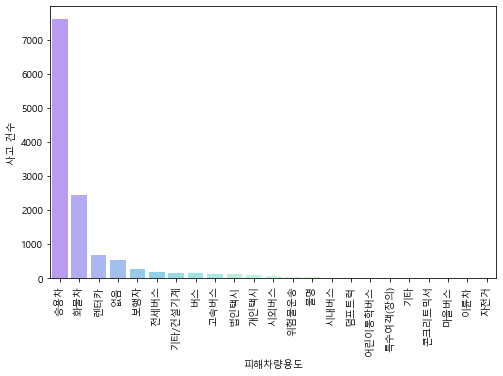

In [93]:
local_list17 = [ df_피해차량용도_dic.get(i) for i in Data_Label17 ]
local_df17 = pd.DataFrame(local_list17).value_counts()
plt.figure(figsize=(8, 5))
sb.barplot([i[0] for i in list(local_df17.index)], local_df17.values, palette='rainbow', alpha=.5)
plt.xticks(rotation = 90)
plt.xlabel('피해차량용도')
plt.ylabel('사고 건수')
plt.show()

#### 기상상태 & 노면상태

In [94]:
lbl22 = LabelEncoder()
Data_Label22 = lbl22.fit_transform( df['노면상태'] )
df_노면상태_dic = { idx : car for idx, car in enumerate(list(lbl22.classes_)) }

lbl23 = LabelEncoder()
Data_Label23 = lbl23.fit_transform( df['기상상태'] )
df_기상상태_dic = { idx : car for idx, car in enumerate(list(lbl23.classes_)) }

df['노면상태'] = Data_Label22
local_list22 = [ df_노면상태_dic.get(i) for i in Data_Label22 ]

df['기상상태'] = Data_Label23
local_list23 = [ df_기상상태_dic.get(i) for i in Data_Label23 ]

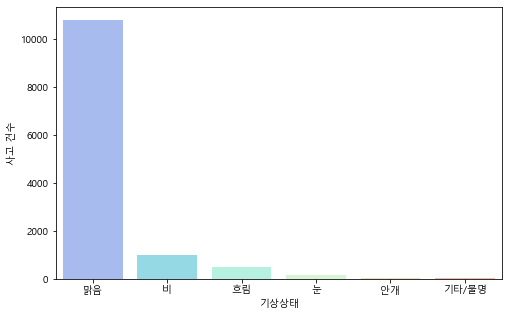

In [95]:
local_df23 = pd.DataFrame(local_list23).value_counts()
plt.figure(figsize=(8, 5))
sb.barplot([i[0] for i in list(local_df23.index)], local_df23.values, palette='rainbow', alpha=.5)
plt.xlabel('기상상태')
plt.ylabel('사고 건수')
plt.show()

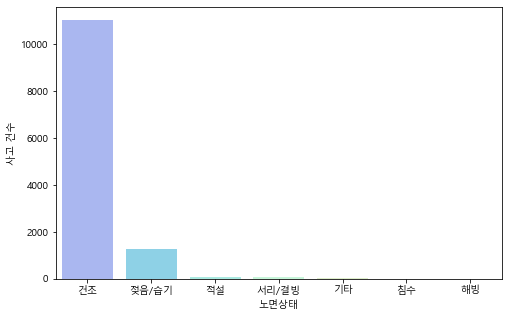

In [96]:
local_list22 = [ df_노면상태_dic.get(i) for i in Data_Label22 ]
local_df22 = pd.DataFrame(local_list22).value_counts()
plt.figure(figsize=(8, 5))
sb.barplot([i[0] for i in list(local_df22.index)], local_df22.values, palette='rainbow', alpha=.5)
plt.xlabel('노면상태')
plt.ylabel('사고 건수')
plt.show()

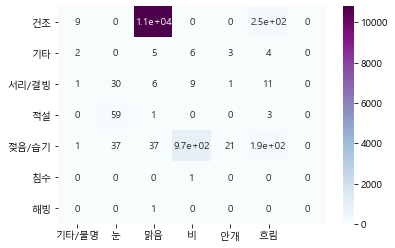

In [97]:
import sklearn.metrics as metrics
df1 = df[['노면상태', '기상상태']]
cm  = metrics.confusion_matrix(df['노면상태'].values, df['기상상태'].values)
sb.heatmap( cm, annot=True, cmap='BuPu', xticklabels=list(lbl23.classes_), yticklabels=list(lbl22.classes_) )
plt.show()

- https://blog.naver.com/chunsa0127/222074830394

In [98]:
def lambda_coefficient(data) :
    max_column  = np.max(data.sum(axis=0))
    denominator = np.sum(data.sum()) - max_column
    numerator   = data.apply(lambda x: np.sum(x)- np.max(x), axis=1)
    numerator   = np.sum(numerator)
    return round(numerator/denominator, 4)

In [99]:
print(f'기상상태와 노면상태의 람다계수 : {lambda_coefficient(df1)}')

기상상태와 노면상태의 람다계수 : 0.7548


#### Feature간의 람다 상관 계수값 파악
- 75% 이하의 조합만을 추출(상대적으로 상관관계가 낮게 판단되는 케이스)
- 발생지_시도 변수가 다른 변수와의 상관성이 상대적으로 매우 낮은 양상을 보임.

In [100]:
# for i , j in list(combinations(df.iloc[:, 1: 25].columns, 2)) :
#     data = df[[i, j]]
#     coef = lambda_coefficient(data)
#     if coef < 0.75 :
#         print(f'{i}와 {j}의 람다 상관 계수값 : {coef}')

#### 데이터 프레임 전처리 정리

In [101]:
# df.to_csv('data1.csv', encoding = 'euc-kr')

#### 지역명 반환 함수

In [100]:
df1 = df.copy()
local_list = [df_발생지_시군구_dic.get(i) for i in df['발생지_시군구']]
df1['발생지_시군구'] = local_list
df2 = df1.groupby('발생지_시군구').mean()['Risk']
df2.to_csv('map.csv')

In [ ]:
df1 = df.copy()
local_list = [df_발생지_시군구_dic.get(i) for i in df['발생지_시군구']]
df1['발생지_시군구'] = local_list
df2 = df1.groupby('발생지_시군구').mean()['응급실 개수']
df2.to_csv('emergency.csv')

In [ ]:
df1 = df.copy()
local_list = [df_발생지_시군구_dic.get(i) for i in df['발생지_시군구']]
df1['발생지_시군구'] = local_list
df2 = df1.groupby('발생지_시군구').mean()['시군구별_인구']
df2.to_csv('pop.csv')